# Image Segmentation with a U-Net-like Architecture
---
At the end of this laboratory, you would get familiarized with:

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**
* This lab must be worked in pairs. Make sure that when you submit your lab you change the name to: **08_lab_Student1FullName_Student2FullName.ipynb**


---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

flag = 0 # 0 for Lloyd, 1 for Ihona

path_to_zip_file_Lloyd = '/content/drive/MyDrive/input.zip'
path_to_zip_file_Ihona = '/content/drive/MyDrive/input.zip'
directory_to_extract_to = '/content/input/'
path_to_zip_file = '' # Leave as an empty string

if flag == 0:
  path_to_zip_file = path_to_zip_file_Lloyd
elif flag == 1:
  path_to_zip_file = path_to_zip_file_Ihona

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# U-net with Covid-19 CT scans dataset

**About the dataset:** This dataset contains 20 CT scans of patients diagnosed with COVID-19 as well as segmentations of lungs and infections made by experts. This dataset provides a CT scan, a lung mask, an infection mask and a lung and infection mask made by experts. We are going to focus on the infection mask as we want to segment this section from a CT.


**1. Load the metadata file provided and understand its content (metadata.csv) (0.5 points)**

In [ ]:
import nibabel as nib  # for loading nii files
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the meta datafile
# No need to change the file path
metadata = pd.read_csv('/content/input/metadata.csv')
metadata.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ct_scan                  20 non-null     object
 1   lung_mask                20 non-null     object
 2   infection_mask           20 non-null     object
 3   lung_and_infection_mask  20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


**2. Load the image dataset into your notebook (data_covid19CT_segmentation folder) (2.5 points)**

*Loading nii files: The image files come on a .nii format, this format is created by Neuroimaging Informatics Technology Initiative. It is commonly used to store magnetic resonance imaging (MRI) data. We are providing you a function to read the images:*

In [ ]:
# Function provided to read the different .nii files
# Slightly modification of the function for convenience
def read_nii(datapath, filepath, verbose=True):
  filepath = filepath.replace("..", "")  # Prevent directory traversal
  path = datapath+filepath
  if verbose:
    print(f"\tLoading file from: {path}")  # Debugging log
  ct_scan = nib.load(path)
  array = ct_scan.get_fdata()
  array = np.rot90(np.array(array))
  return array

**2.1 Read all the nii files for the second observation of the csv file (ct scan, lung, infection and the lung and infection mask as well). Print the ct scan dimensions.**

In [ ]:
def process_observation(metadata:pd.DataFrame, index_observation:int, verbose=True):
  # Use the metadata to get the scan and mask filepaths base on the "input" file
  ct_scan_path = str(metadata.loc[index_observation, 'ct_scan'])
  infection_mask_path = str(metadata.loc[index_observation, 'infection_mask'])
  # Get the name of the scan and mask
  ct_scan_name = ct_scan_path.split('/')[-1].replace('.nii', '')
  infection_mask_name = infection_mask_path.split('/')[-1].replace('.nii', '')

  print(f"\nProcessing scan and mask pair {index_observation} (Observation #{index_observation+1})")
  try:
    scan_array = read_nii('/content', ct_scan_path, verbose=verbose)
    mask_array = read_nii('/content', infection_mask_path, verbose=verbose)
    print(f"\tSuccessfully loaded images.")
    return ct_scan_name, infection_mask_name, scan_array, mask_array
  except Exception as e:
    print(f"Error processing scan and mask pair {index_observation}:\n\t {e}")

In [ ]:
scan_name, mask_name, scan_array, mask_array = process_observation(metadata, 1, verbose=True)
print(f"CT scan shape:\t\t{scan_array.shape}")
print(f"Infection mask shape:\t{mask_array.shape}")


Processing scan and mask pair 1 (Observation #2)
	Loading file from: /content/input/covid19-ct-scans/ct_scans/coronacases_org_002.nii
	Loading file from: /content/input/covid19-ct-scans/infection_mask/coronacases_002.nii
	Successfully loaded images.
CT scan shape:		(512, 512, 200)
Infection mask shape:	(512, 512, 200)


Explain the shape of the observation loaded. What does the third dimension represents?

**Solution**

Each file is a sigle scan that is attributed to one patient where the third dimension corresponds to the slices of the scan for that patient.

**2.2 Visualizing input image and corresponding segmentation mask**

Produce two plots side by side:
*   First plot should be the visualization of CT scan with index 30 from the ct sample read in the previous step.
*   Second plot should show the corresponding mask overlayed on the original image.
*   Use cmap = 'bone', this palette is a grayscale colormap that is commonly used for representing data as shades of gray.

Make sure to add titles.

In [ ]:
def plot_scan_mask_pair(scan:np.array, scan_name:str,
                        mask:np.array, mask_name:str,
                        indexes_to_plot:list=[0]):

  # from arrays of slices for the scans and masks plot the
  # slice at the specified indexes:
  if (scan.shape == mask.shape) and (len(scan) > 0) and (len(mask) > 0): # Check that the arrays are not empty and have the same shape
    fig, ax = plt.subplots(len(indexes_to_plot), 2,
                           figsize=(5, 10))
    ax = ax.flatten()
    # arrays used to position the scan and mask slices across the axes
    position_scan = range(0, len(indexes_to_plot)*2, 2)
    position_mask = range(1, len(indexes_to_plot)*2, 2)
    # add each scan and mask slice to the plot that correspond with the specified indexes
    for x, index in enumerate(indexes_to_plot):
      ax[position_scan[x]].imshow(scan[:, :, index], cmap='bone')
      ax[position_scan[x]].set_title(f'CT scan:\n{scan_name},\nSlice Index: {index}')
      ax[position_scan[x]].axis('off')
      ax[position_mask[x]].imshow(mask[:, :, index], cmap='gray')
      ax[position_mask[x]].set_title(f'Infection mask:\n{mask_name},\nSlice Index: {index}')
      ax[position_mask[x]].axis('off')
    fig.tight_layout()
    return fig, ax
  else:
    print("Invalid input")
    return None

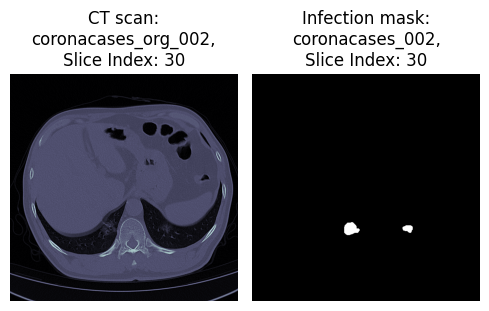

In [ ]:
slice_index = 30 # specific index to plot
fig, ax = plot_scan_mask_pair(scan_name=scan_name, scan=scan_array,
                          mask_name=mask_name, mask=mask_array,
                          indexes_to_plot=[slice_index])
plt.show()

**2.3 Print the structure/shape of one CT image on the dataset.**
* How many color channels does this image has? How does this impact the modeling?

In [ ]:
slice_index=30
scan_array[:,:,slice_index].shape

(512, 512)

**Solution**

The CT scan image (corresponding to the slice at index 30 of the scan) has 1 colour channel and the dimensions of the image is 512x512. Each pixel is represented by a single intensity value reducing the complexity of the data.

**2.4 Loading Input Images and Segmentation Masks**

*   Prepare data to train the model, use only the ct scans as your training data/features and the infection masks as the ground truth as we will focus only on this problem and not the other masks available.
*   Make sure images are resize to 128x128 so the training is faster. Use cv2 function for this.
*   Your final objects should be arrays of size: (3250,128,128,1)

Hint: You can create a for loop to go through each observation from the dataframe and read the appropriate files.
Remember that each observation has multiple slices stored.

Here is a starter code:

```python
import cv2
from tqdm import tqdm
cts = []
infections = []
img_size = (128,128)

for i in tqdm(range(len(data))):
  # Read nii for ct and infections
  for ii in range(ct.shape[dim]): #change dim to the dimension that you want to loop :)
    ct_img = cv2.resize(ct[ii], dsize = img_size,interpolation = cv2.INTER_AREA).astype('uint8')
    # Repeat process for infections
    # Append them to cts and infections

infections = np.array(infections)
cts = np.array(cts)
pritn(cts.shape)
```

In [ ]:
#solution
import cv2
from tqdm import tqdm

cts = []
infections = []
img_size = (128,128)

for scan_number in tqdm(range(metadata.shape[0])):
  # Read nii for ct and infections
  _, _, scan_array, mask_array = process_observation(metadata, scan_number, verbose=False)
  for i in range(scan_array.shape[2]):
    ct_img = cv2.resize(scan_array[i], dsize = img_size, interpolation = cv2.INTER_AREA).astype('uint8')
    # Repeat process for infections
    mask_img = cv2.resize(mask_array[i], dsize = img_size, interpolation = cv2.INTER_AREA).astype('uint8')
    # Append them to cts and infections
    cts.append(ct_img)
    infections.append(mask_img)

cts = np.array(cts)
infections = np.array(infections)
# add fourth dimension to ct scans and infections
cts = np.expand_dims(cts, axis=-1)
infections = np.expand_dims(infections, axis=-1)

  0%|          | 0/20 [00:00<?, ?it/s]


Processing scan and mask pair 0 (Observation #1)
	Successfully loaded images.


  5%|▌         | 1/20 [00:03<00:59,  3.14s/it]


Processing scan and mask pair 1 (Observation #2)
	Successfully loaded images.


 10%|█         | 2/20 [00:04<00:33,  1.88s/it]


Processing scan and mask pair 2 (Observation #3)
	Successfully loaded images.


 15%|█▌        | 3/20 [00:05<00:28,  1.67s/it]


Processing scan and mask pair 3 (Observation #4)
	Successfully loaded images.


 20%|██        | 4/20 [00:08<00:34,  2.14s/it]


Processing scan and mask pair 4 (Observation #5)
	Successfully loaded images.


 25%|██▌       | 5/20 [00:10<00:34,  2.30s/it]


Processing scan and mask pair 5 (Observation #6)
	Successfully loaded images.


 30%|███       | 6/20 [00:12<00:28,  2.04s/it]


Processing scan and mask pair 6 (Observation #7)
	Successfully loaded images.


 35%|███▌      | 7/20 [00:14<00:25,  1.97s/it]


Processing scan and mask pair 7 (Observation #8)
	Successfully loaded images.


 40%|████      | 8/20 [00:17<00:26,  2.21s/it]


Processing scan and mask pair 8 (Observation #9)
	Successfully loaded images.


 45%|████▌     | 9/20 [00:18<00:23,  2.11s/it]


Processing scan and mask pair 9 (Observation #10)
	Successfully loaded images.


 50%|█████     | 10/20 [00:22<00:24,  2.50s/it]


Processing scan and mask pair 10 (Observation #11)


 55%|█████▌    | 11/20 [00:22<00:16,  1.81s/it]

	Successfully loaded images.

Processing scan and mask pair 11 (Observation #12)
	Successfully loaded images.


 60%|██████    | 12/20 [00:26<00:19,  2.50s/it]


Processing scan and mask pair 12 (Observation #13)


 65%|██████▌   | 13/20 [00:27<00:13,  1.87s/it]

	Successfully loaded images.

Processing scan and mask pair 13 (Observation #14)


 70%|███████   | 14/20 [00:27<00:08,  1.42s/it]

	Successfully loaded images.

Processing scan and mask pair 14 (Observation #15)


 75%|███████▌  | 15/20 [00:27<00:05,  1.07s/it]

	Successfully loaded images.

Processing scan and mask pair 15 (Observation #16)


 80%|████████  | 16/20 [00:27<00:03,  1.22it/s]

	Successfully loaded images.

Processing scan and mask pair 16 (Observation #17)


 85%|████████▌ | 17/20 [00:28<00:01,  1.53it/s]

	Successfully loaded images.

Processing scan and mask pair 17 (Observation #18)


 90%|█████████ | 18/20 [00:28<00:01,  1.61it/s]

	Successfully loaded images.

Processing scan and mask pair 18 (Observation #19)


 95%|█████████▌| 19/20 [00:28<00:00,  2.00it/s]

	Successfully loaded images.

Processing scan and mask pair 19 (Observation #20)


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]

	Successfully loaded images.


In [ ]:
# print final array shapes
print(f"CT scans shape:\t\t{cts.shape}")
print(f"Infection masks shape:\t{infections.shape}")

CT scans shape:		(3520, 128, 128, 1)
Infection masks shape:	(3520, 128, 128, 1)


**2.5 Split into train and test, use 10% of all the images for test set. You can use sklearn function for this.**

In [ ]:
from sklearn.model_selection import train_test_split
# split the data into training and test test sets
ct_train, ct_test, infect_train, infect_test = train_test_split(cts, infections, test_size=0.1, random_state=42)
# split the training data into training and validation sets
ct_train, ct_val, infect_train, infect_val = train_test_split(ct_train, infect_train, test_size=0.1, random_state=42)

**Creating the Image Generator**

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should at least have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

We have provided you a code for this, you can change some things if you like or if it is causing you any trouble with your previous data processing. In the provided code, \_data_generation is very similar to the code for loading the nii files, where you resized and kept appending over a loop the different files. The difference comes from now using *indexes* specifying the batch you are working with. __get_item__ returns the values of the batch, get_masks returns only masks (but same logic as _data_generation).

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class ImageDataGenerator(Sequence):
  def __init__(self, ct_data, infect_data, data_path, batch_size, img_size):
    self.ct_data = ct_data
    self.infect_data = infect_data
    self.data_path = data_path  # Added data_path parameter
    self.batch_size = batch_size
    self.img_size = img_size
    self.indexes = np.arange(len(self.ct_data))
    #np.random.shuffle(self.indexes)

  def __len__(self):
    return (len(self.ct_data) + self.batch_size - 1) // self.batch_size

  def __getitem__(self, index):
    start_idx = index * self.batch_size
    end_idx = (index + 1) * self.batch_size
    if end_idx > len(self.ct_data):
        end_idx = len(self.ct_data)
    indexes = self.indexes[start_idx:end_idx]
    batch_ct, batch_infect = self.__data_generation(indexes)
    return batch_ct, batch_infect

  def __data_generation(self, indexes):
    batch_ct = []
    batch_infect = []
    for i in indexes:
      ct = self.ct_data[i]
      infect = self.infect_data[i]
      ct_img = cv2.resize(ct, dsize=(self.img_size[0], self.img_size[1]),
                          interpolation=cv2.INTER_AREA).astype('float32')
      infect_img = cv2.resize(infect, dsize=(self.img_size[0], self.img_size[1]),
                              interpolation=cv2.INTER_AREA).astype('uint8')
      batch_ct.append(np.expand_dims(ct_img, axis=-1))
      batch_infect.append(np.expand_dims(infect_img, axis=-1))

    batch_ct = np.array(batch_ct)
    batch_infect = np.array(batch_infect)
    return batch_ct, batch_infect

  def get_masks(self):
    masks = []
    for i in range(len(self.ct_data)):
      infect = self.infect_data[i]
      infect_img = cv2.resize(infect, dsize=(self.img_size[0], self.img_size[1]),
                              interpolation=cv2.INTER_AREA).astype('uint8')
      masks.append(np.expand_dims(infect_img, axis=-1))
    return np.array(masks)


**3. U-Net Xception-style model architecture (1.5 point)**

3.1 We will use the same model architecture that we followed in the tutorial for this exercise, instantiate the model. Print the summary of the model architecture.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes, n_channels):
  inputs = keras.Input(shape=img_size + (n_channels,))

  ### [First half of the network: downsampling inputs] ###

  # Entry block
  x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in [64, 128, 256]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  ### [Second half of the network: upsampling inputs] ###

  for filters in [256, 128, 64, 32]:
      x = layers.Activation("relu")(x)
      x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.UpSampling2D(2)(x)

      # Project residual
      residual = layers.UpSampling2D(2)(previous_block_activation)
      residual = layers.Conv2D(filters, 1, padding="same")(residual)
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  # Add a per-pixel classification layer
  outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
# Build model
image_size = (128, 128)
num_classes = 1
n_channels = 1
model = get_model(img_size, num_classes, n_channels)

In [ ]:
# To see the summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 64, 32)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 64, 64, 64)     │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 64, 64, 64)     │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 32, 32, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,057,825 (7.85 MB)

 Trainable params: 2,054,049 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

**3.2 Create Image Generators for each split**

*   For this experiment, we will use the test split as the validation generator. Use the class ImageDataGenerator created before to create our train and validation set.

In [ ]:
# use the training and test data to create Image Generators from the specified class above
batch_size = 8
image_size = (128, 128)
train_generator = ImageDataGenerator(ct_train, infect_train, data_path='', batch_size=batch_size, img_size=image_size)
val_generator = ImageDataGenerator(ct_val, infect_val, data_path='', batch_size=batch_size, img_size=image_size)
test_generator = ImageDataGenerator(ct_test, infect_test, data_path='', batch_size=batch_size, img_size=image_size)

**3.3 For the first 3 batches, print the X and Y shape (image and mask structure)**

You can expect the output to be similar to this:
> Train Generator: \
  Batch 1:\
  Batch X shape: (8, 128, 128, 1)\
  Batch Y shape: (8, 128, 128, 1)\
  Batch 2:\
  Batch X shape: (8, 128, 128, 1)\
  Batch Y shape: (8, 128, 128, 1)\
  Batch 3:\
  Batch X shape: (8, 128, 128, 1)\
  Batch Y shape: (8, 128, 128, 1)

In [ ]:
for i in range(3):
  batch_x, batch_y = train_generator[i]
  print(f"Batch {i+1}:")
  print(f"Batch X shape: {batch_x.shape}")
  print(f"Batch Y shape: {batch_y.shape}")

Batch 1:
Batch X shape: (8, 128, 128, 1)
Batch Y shape: (8, 128, 128, 1)
Batch 2:
Batch X shape: (8, 128, 128, 1)
Batch Y shape: (8, 128, 128, 1)
Batch 3:
Batch X shape: (8, 128, 128, 1)
Batch Y shape: (8, 128, 128, 1)


**4. Train Model (2 points)**

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    --> **This is wrong since it is binary classification problem we need to used Binary Crossentropy Loss**
    *   Use 'rmsprop' optimizer
*   Instantiate a ModelCheckpoint callback to save only the best model
*   Train the model using fit method. Train for 25 epochs, with a batch size of 8.

In [ ]:
# We will free up the RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [ ]:
# Compile model for training
model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(from_logits=True))
# Define callbacks
callbacks = [keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)]

# Train model for 25 epochs with a batch size of 8, ensure to validate
epochs = 25
batch_size = 8
model.fit(train_generator, epochs=epochs,
          validation_data=val_generator,
          batch_size=batch_size, callbacks=callbacks)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.0827 - val_loss: 0.0163
Epoch 2/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0119 - val_loss: 0.0072
Epoch 3/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 4/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 5/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 7/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 8/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 10/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 11/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 12/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 

**5. Obtain predictions and performance metrics (1.5 point)**

*   Generate predictions for all images in the validation set
*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.
*   Use the test mask images to compare with the results (get_mask method of the generator class): Find the DICE similarity score for the test/validation set.
Here is a function to calculate the value

```python
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

```

In [ ]:
# Make predictions based on the test set
test_preds = model.predict(test_generator)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Get masks
test_masks = test_generator.get_masks()

In [ ]:
print(f"Test predictions shape: {test_preds.shape}")
print(f"Test masks shape: {test_masks.shape}")

Test predictions shape: (352, 128, 128, 1)
Test masks shape: (352, 128, 128, 1)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = np.expand_dims(y_true.flatten(), axis=-1).reshape(1, -1)
  y_pred_f = np.expand_dims(y_pred.flatten(), axis=-1).reshape(1, -1)

  # find the common elements in both arrays
  intersection = y_true_f * y_pred_f
  # calculate the dice score
  return (2. * np.sum(y_pred_f[np.logical_not(np.isnan(y_pred_f))]) + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [ ]:
dice_scores = []
for i in range(len(test_preds)):
  dice_score = dice_coef(test_masks[i], test_preds[i])
  dice_scores.append(dice_score)

mean_dice_score = np.mean(dice_scores)
print(f"Mean Dice Score: {mean_dice_score}")

Mean Dice Score: 0.9641041667099891


*   Is this model performing well?
*   What are other evaluation metrics to compare the performance of segmentation? Which parameter is used for what type of problem?
*   What do you understand from the 'average' parameter of the similarity score function?

**Solution**

The Dice score is very high, indicating a very good segmentation performance.

Other evaluation metrics include the Intersection over Union (IoU), which quantifies the overlap between predicted and true regions. Like the dice, they are metrics for segmentation overlap and are widely used in medical imaging and natural images problems.
Moreover, the Hausdorff Distance measures the maximum distance between the predicted boundary and the ground truth boundary. It is useful for segmenting objects with sharp boundaries such as organs and tumors, which require a precise boundary localization.

The average parameter in similarity score functions like Dice or IoU for instance, determines how the metric is computed across multiple classes or samples. For example, the micro averaging type calculates metrics globally by aggregating true positives, false positives, and false negatives across all classes.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [ ]:
Y_true_all = []
Y_pred_all = []
for i in range(len(test_preds)):
  y_true_f = np.expand_dims(test_masks[i].flatten(), axis=-1).reshape(1, -1)
  y_pred_f = np.expand_dims(test_preds[i].flatten(), axis=-1).reshape(1, -1)

  # Convert predictions to binary using a threshold (e.g., 0.5)
  y_pred_f = (y_pred_f > 0.5).astype(int)
  y_true_f = y_true_f.astype(int) # Ground truth is already binary {0, 1}

  Y_true_all.extend(y_true_f[0])
  Y_pred_all.extend(y_pred_f[0])

# Convert the lists to NumPy arrays for the confusion matrix
Y_true_all = np.array(Y_true_all)
Y_pred_all = np.array(Y_pred_all)

# Calculate evaluation metrics
accuracy = accuracy_score(y_pred=Y_pred_all, y_true=Y_true_all)
precision = precision_score(y_pred=Y_pred_all, y_true=Y_true_all, average='weighted', zero_division=0)
recall = recall_score(y_pred=Y_pred_all, y_true=Y_true_all, average='weighted', zero_division=0)
f1 = f1_score(y_pred=Y_pred_all, y_true=Y_true_all, average='weighted', zero_division=0)

print(f"Mean Accuracy: {accuracy:.4f}")
print(f"Mean Precision: {precision:.4f}")
print(f"Mean Recall: {recall:.4f}")
print(f"Mean F1 Score: {f1:.4f}")

Mean Accuracy: 0.6477
Mean Precision: 0.2099
Mean Recall: 0.2099
Mean F1 Score: 0.2099


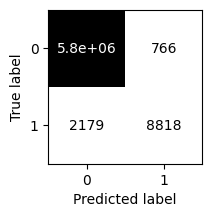

In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2,2))
Y_true_all = []
Y_pred_all = []
for i in range(len(test_preds)):
  y_true_f = np.expand_dims(test_masks[i].flatten(), axis=-1).reshape(1, -1)
  y_pred_f = np.expand_dims(test_preds[i].flatten(), axis=-1).reshape(1, -1)

  # Convert predictions to binary using a threshold (e.g., 0.5)
  y_pred_f = (y_pred_f > 0.5).astype(int)
  y_true_f = y_true_f.astype(int) # Ground truth is already binary {0, 1}

  Y_true_all.extend(y_true_f[0])
  Y_pred_all.extend(y_pred_f[0])

# Convert the lists to NumPy arrays for the confusion matrix
Y_true_all = np.array(Y_true_all)
Y_pred_all = np.array(Y_pred_all)

cm = ConfusionMatrixDisplay.from_predictions(y_true=Y_true_f, y_pred=Y_pred_f,
                                             display_labels=[0, 1],
                                             cmap= 'binary',
                                             colorbar=False,
                                             ax=ax)
plt.show()

**6. Display one image with infection: Its CT, overlayed groundtruth mask, overlayed prediction mask using matplotlib (3 images) (1 point)**

<img src="https://drive.google.com/uc?export=view&id=1P6UXNyLNin2nwTWJw0-2RqnX3uuerkfh">

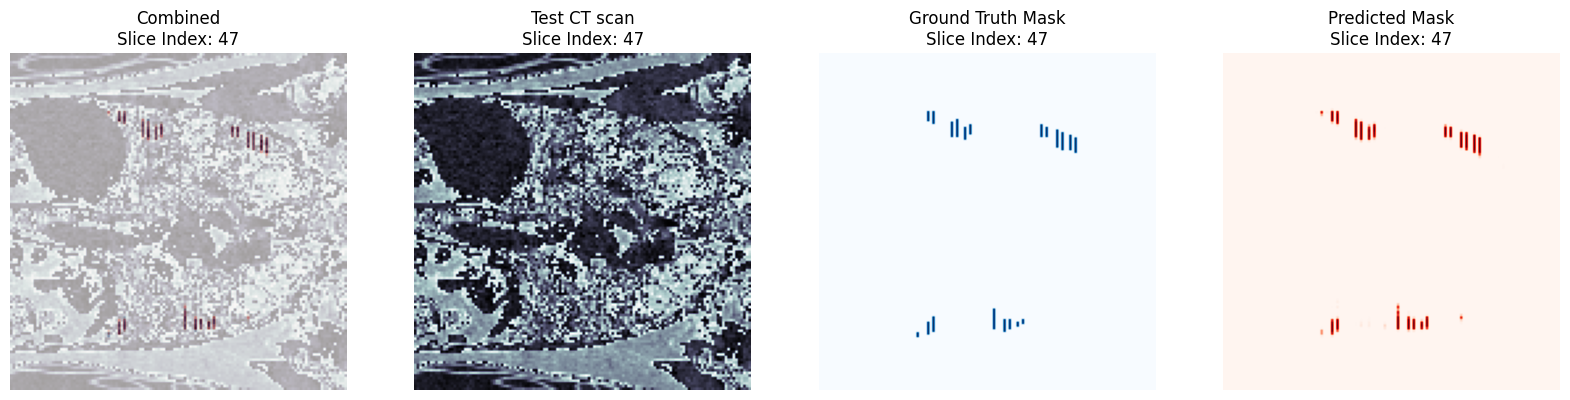

In [ ]:
# show the original slice and mask of a test ct image with infection
slice_index = 47
for i, batch in enumerate(test_generator):
  temp = range(i*batch_size, (i+1)*batch_size, 1)
  if slice_index in temp:
    batch_scan, batch_mask = batch
    # get the index of temp that equals slice index
    index = temp.index(slice_index)
    scan = batch_scan[index, :, :]
    mask_GT = batch_mask[index, :, :]
    predicted_mask = test_preds[slice_index, :, :]

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(scan, cmap='bone', vmin=0, vmax=255)
    ax[0].imshow(mask_GT, cmap='Blues', vmin=0, vmax=1, alpha=0.4)
    ax[0].imshow(predicted_mask, cmap='Reds', vmin=0, vmax=1, alpha=0.4)
    ax[0].set_title(f'Combined\nSlice Index: {slice_index}')
    ax[0].axis('off')
    ax[1].imshow(scan, cmap='bone', vmin=0, vmax=255)
    ax[1].set_title(f'Test CT scan\nSlice Index: {slice_index}')
    ax[1].axis('off')
    ax[2].imshow(mask_GT, cmap='Blues', vmin=0, vmax=1)
    ax[2].set_title(f'Ground Truth Mask\nSlice Index: {slice_index}')
    ax[2].axis('off')
    ax[3].imshow(predicted_mask, cmap='Reds', vmin=0, vmax=1)
    ax[3].set_title(f'Predicted Mask\nSlice Index: {slice_index}')
    ax[3].axis('off')
    break


**7. To think further... Theoretical questions (1 point)**

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

In semantinc segmentation, all the objects of the same class are marked using one class label, wherease in the instance segmentation, similar objects get their own separate labels (being a mix between object detection and segmentation).
For example, in an image with two cats and a dog, semantic segmentation would label all cat pixels with the same label "cat" and all dogs with "dog". However, in instance segmentation, the two cats would have separate masks ("cat1" and "cat2"), and the dog would have its own mask ("dog1").


*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

The purpose of the encoder is to extract features from the input image. It  reduces the spatial dimensions of the input progressively while capturing the context and the high-level features. On the other hand, the decoder reconstructs the spatial dimensions from the compressed feature map produced by the encoder. We can say it progressively restores fine-grained details.
The output of the decoder is a segmentation mask where each pixel is classified into a specific class.

Finally, the encoder and the decoder perform different tasks, so they do not need to have the same type of neural network or architecture.

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

Feature channels are an important part of U-Net because they allow the network to learn a hierarchy of features, from low-level details to high-level, while maintaining a balance between the context and localization. In summary, they represent the number of filters or feature detectors applied during a convolution operation. Increasing feature channels in the encoder helps capture a wide range of features (for example edges, textures, patterns). On the other hand, as the spatial dimensions are restored in the decoder, the number of feature channels decreases.



*   What are the other popular semantic segmentation algorithms?
*   How are they different from each other?

**Solution**

One popular semantic segmentation algorithm is the Fully Convolutional Network, which replaces fully connected layers in standard CNNs with convolutional layers to produce pixel-level predictions. This algorithm is simple, is used for general segmentation and has a limited global context understanding.

Another algorithm can be SegNet, which also uses an encoder-decoder architecture and uses memory efficiently by reusing pooling indices for upsampling. It is simpler than UNET and it is used for real-time applications, although it normally has lower accuracy.



...

*   What are the popular semantic segmentation datasets which are available for public access?

**Solution**

There are several ones, for example:

- MS COCO (Microsoft Common Objects in Context)
-Imagenet
- KITTI

...


---

## **End of Image Segmentation using UNet**